In [17]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

In [130]:
# path_frc = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_uwind_5.8_windtype_2_dx_500_frc.nc'
path_frc = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_uwind_005_frc.nc'
dsf = xr.open_dataset(path_frc)
time = (dsf.sms_time.values.astype(float))/10**9/86400 #nanoseconds to days 

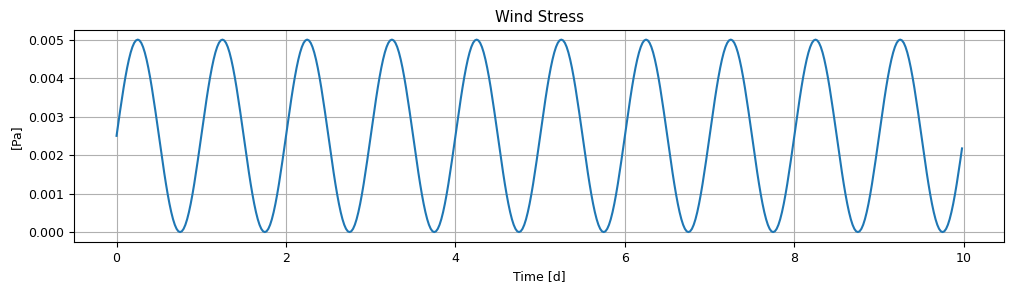

In [131]:
fig, ax = plt.subplots(1, figsize = (12,2.75))
plt.plot(time[:480], dsf.sustr[:480])
plt.xlabel('Time [d]')
plt.ylabel('[Pa]')
plt.title('Wind Stress')
plt.grid()
p

In [134]:
# path = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/basecase/shelf_ho_5_dx_500_avg.nc'
path2 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_005/shelf_dx_500_mpdata_uwind_005_avg.nc'
path4 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_05/shelf_dx_500_mpdata_uwind_05_avg.nc'
# path2 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/downwelling_5_semidiurnal/shelf_ho_5_dx_500_uwind_4_semidiurnal_avg.nc'

# ds_base = xroms.open_netcdf(path)
# ds_base, grid_base = xroms.roms_dataset(ds_base)

# ds_001 = xroms.open_netcdf(path1)
# ds_001, grid_001 = xroms.roms_dataset(ds_001)

ds_005 = xroms.open_netcdf(path2)
ds_005, grid_005 = xroms.roms_dataset(ds_005)
ds_005 = ds_005.isel(ocean_time = slice(0,240))

# ds_01 = xroms.open_netcdf(path1)
# ds_01, grid_01 = xroms.roms_dataset(ds_01)

ds_05 = xroms.open_netcdf(path4)
ds_05, grid_05 = xroms.roms_dataset(ds_05)
ds_05 = ds_05.isel(ocean_time = slice(0,240))

# ds_1 = xroms.open_netcdf(path1)
# ds_1, grid_1 = xroms.roms_dataset(ds_1)

# ds_2 = xroms.open_netcdf(path1)
# ds_2, grid_2 = xroms.roms_dataset(ds_2)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

In [137]:
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dudy = xroms.to_rho(dudy, grid)
    dvdx = grid.derivative(v, 'X')
    dvdx = xroms.to_rho(dvdx, grid)

    rvort_rho = (dvdx-dudy)/ds.f
    
    return rvort_rho 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_rho(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_rho(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

In [38]:
# plt.plot(ds_05.sustr.mean(['eta_rho','xi_u']).values)

In [144]:
plt.rcParams.update({'font.size': 9})

def make_plts(ds,vort1, vortfinal, sgrad1, sgradfinal):
    fig, ax = plt.subplots(3,2, figsize = (7,8), constrained_layout=True)

    #salt
    mappable = ax[0,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, ds.salt[0,-1][1:], cmap = cmo.haline, vmin = 27, vmax = 35)
    mappable = ax[0,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, ds.salt[-1,-1][1:], cmap = cmo.haline, vmin = 27, vmax = 35)
    cbar = fig.colorbar(mappable, ax = ax[0,1], label = '', pad = 0.03, ticks = [27, 29, 31, 33, 35],)
    cbar.ax.set_ylabel(r'[g kg$^{-1}$]')

    mappable = ax[1,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgrad1[1:].where(sgrad1[1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
    mappable = ax[1,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgradfinal[1:].where(sgradfinal[1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
    cbar = fig.colorbar(mappable, ax = ax[1,1], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'), pad = 0.03,
                       ticks = [-6,-5,-4,-3,-2])
    cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

    mappable = ax[2,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, vort1[1:], cmap = cmo.curl, vmin = -3, vmax = 3)
    mappable = ax[2,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, vortfinal[1:], cmap = cmo.curl, vmin = -3, vmax = 3)
    cbar = fig.colorbar(mappable, ax = ax[2,1], label = '', extend = 'both', pad = 0.03, ticks = [-3,-2,-1,0,1,2,3])
    cbar.ax.set_ylabel(r'$(\partial_x v - \partial_y u)/f$')

    for i in range(3):
        for j in range(2):
            ax[i,j].set(xlim=[0,97], ylim=[0,97])
            ax[i,0].set_ylabel('Across-shore Dist. [km]')
            ax[2,j].set_xlabel('Along-shore Dist. [km]')
            ax[i,1].set_yticklabels([])
            minor_locator = AutoMinorLocator(2)
            ax[i,j].xaxis.set_minor_locator(minor_locator)
            ax[i,j].yaxis.set_minor_locator(minor_locator)
            ax[i,j].set_aspect(0.8)

    for i in range(2):
        for j in range(2):
            ax[i,j].set_xticklabels([])

    ax[0,0].set_title(r'Initial salinity')
    ax[0,1].set_title(r'Salinity: t = 10 days')
    ax[1,0].set_title(r'Initial $|\nabla_H s|$')
    ax[1,1].set_title(r'$|\nabla_H s|$: t = 10 days')
    ax[2,0].set_title(r'Initial $\zeta/f$')
    ax[2,1].set_title(r'$\zeta/f$: t = 10 days')

    ax[0,0].annotate('(a)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
    ax[0,1].annotate('(b)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
    ax[1,0].annotate('(c)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
    ax[1,1].annotate('(d)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
    ax[2,0].annotate('(e)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
    ax[2,1].annotate('(f)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
    # fig.tight_layout()
    # plt.subplots_adjust(wspace = 0)
    # plt.savefig('shelfstrat_overview.jpg', dpi = 300, bbox_inches='tight')

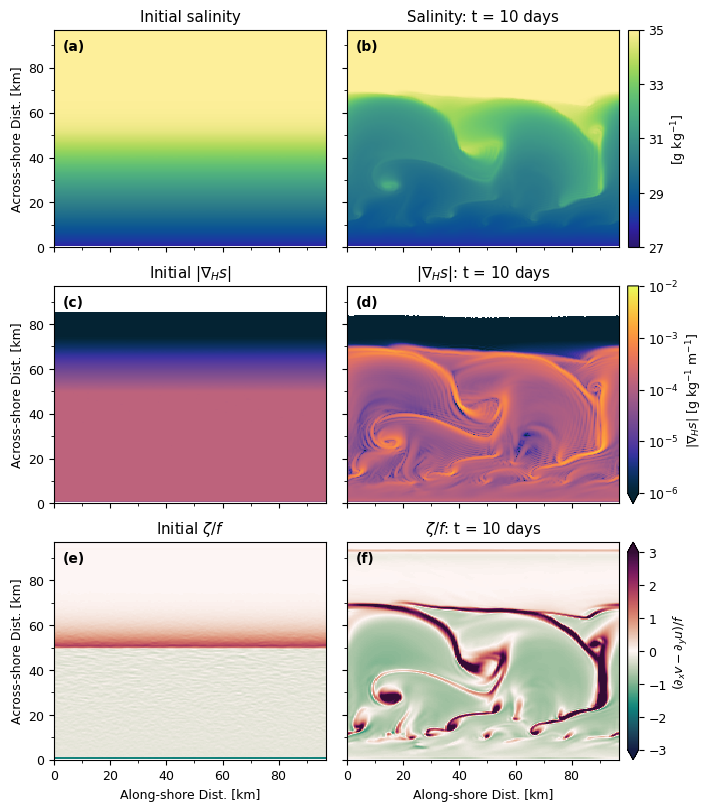

In [145]:
sgradmag = surface_saltgradmag(ds_005, grid_005)
rv = surface_vorticity(ds_005, grid_005)

vort1 = rv[0].load()
vortfinal = rv[-1].load()
sgrad1 = sgradmag[0].load()
sgradfinal = sgradmag[-1].load()

make_plts(ds_005, vort1, vortfinal, sgrad1, sgradfinal)

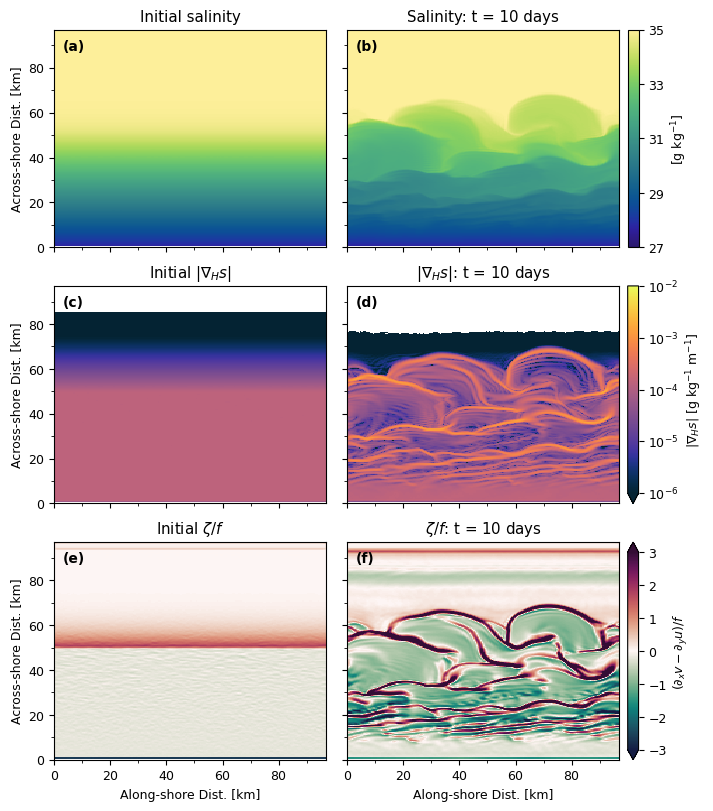

In [148]:
sgradmag = surface_saltgradmag(ds_05, grid_05)
rv = surface_vorticity(ds_05, grid_05)

vort1 = rv[0].load()
vortfinal = rv[-1].load()
sgrad1 = sgradmag[0].load()
sgradfinal = sgradmag[-1].load()

make_plts(ds_05, vort1, vortfinal, sgrad1, sgradfinal)

In [153]:
etaslice = slice(10,51)
xislice = slice(1,-1)

def compute_mix(ds,grid):
    mnum = ds.dye_03.isel(eta_rho = etaslice, xi_rho = xislice)
    mphy = ds.AKr.isel(eta_rho = etaslice, xi_rho = xislice)
    mphy = grid.interp(mphy, 'Z')
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)

    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    
    return mnum_int, mphy_int

# mnum_int_base, mphy_int_base = compute_mix(ds_base,grid_base)
mnum_int_005, mphy_int_005 = compute_mix(ds_005,grid_005)
mnum_int_05, mphy_int_05 = compute_mix(ds_05,grid_05)
# mnum_int_01, mphy_int_01 = compute_mix(ds_01,grid_01)

In [161]:
time = np.arange(0,240)/24

In [165]:
# print(mnum_int_base.sum().values/(mphy_int_base.sum().values))
# print(mnum_int_01.sum().values/(mphy_int_01.sum().values))
# print(mnum_int_base.sum().values/(mphy_int_base.sum().values))
print(mnum_int_005.sum().values/(mphy_int_005.sum().values))
print(mnum_int_05.sum().values/(mphy_int_05.sum().values))

0.0896211740107709
0.08507548589691918


Text(0.5, 1.0, 'Volume-integrated mixing comparison')

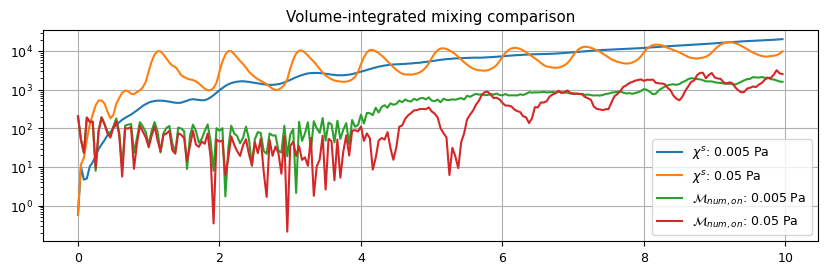

In [168]:
fig, ax = plt.subplots(1, figsize = (10,2.75))

# plt.plot(time, mphy_int_base, label = r'$\chi^s$: basecase')
# plt.plot(time, mphy_int_01, label = r'$\chi^s$: 0.01 Pa')
plt.semilogy(time, np.abs(mphy_int_005), label = r'$\chi^s$: 0.005 Pa')
plt.semilogy(time, np.abs(mphy_int_05), label = r'$\chi^s$: 0.05 Pa')
# plt.plot(time, mnum_int_base, label = r'$\mathcal{M}_{num,on}$: basecase')
plt.semilogy(time, np.abs(mnum_int_005), label = r'$\mathcal{M}_{num,on}$: 0.005 Pa')
plt.semilogy(time, np.abs(mnum_int_05), label = r'$\mathcal{M}_{num,on}$: 0.05 Pa')
# plt.plot(time, mnum_int_01, label = r'$\mathcal{M}_{num,on}$: 0.01 Pa')

plt.grid()
plt.legend()
plt.title('Volume-integrated mixing comparison')

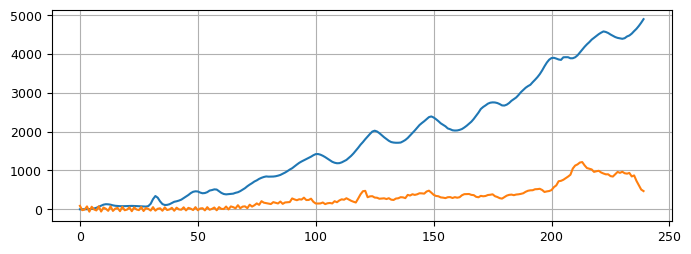

In [56]:
fig, ax = plt.subplots(1, figsize = (8,2.75))

plt.plot(mphy_int, label = r'$\chi^s$')
plt.plot(mnum_int, label = r'$\mathcal{M}_{num,on}$')
plt.grid()

In [5]:
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dudy = xroms.to_rho(dudy, grid)
    dvdx = grid.derivative(v, 'X')
    dvdx = xroms.to_rho(dvdx, grid)

    rvort_rho = (dvdx-dudy)/ds.f
    
    return rvort_rho 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_rho(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_rho(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

sgradmag = surface_saltgradmag(ds, grid)
rv = surface_vorticity(ds, grid)

salt1 = ds.salt[0,-1].load()
saltfinal = ds.salt[-1,-1].load()
vort1 = rv[0].load()
vortfinal = rv[-1].load()
sgrad1 = sgradmag[0].load()
sgradfinal = sgradmag[-1].load()

In [6]:
from matplotlib.ticker import AutoMinorLocator

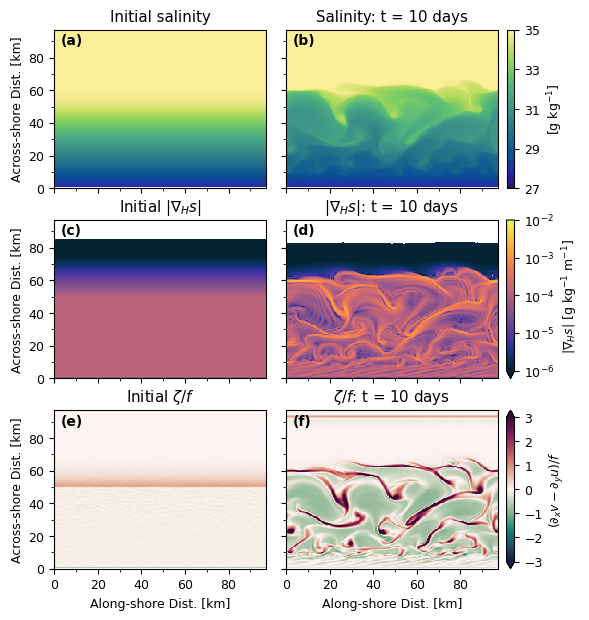

In [7]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(3,2, figsize = (7,7))

#salt
mappable = ax[0,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, salt1[1:], cmap = cmo.haline, vmin = 27, vmax = 35)
mappable = ax[0,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, saltfinal[1:], cmap = cmo.haline, vmin = 27, vmax = 35)
cbar = fig.colorbar(mappable, ax = ax[0,1], label = '', pad = 0.03, ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'[g kg$^{-1}$]')

mappable = ax[1,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgrad1[1:].where(sgrad1[1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
mappable = ax[1,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgradfinal[1:].where(sgradfinal[1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable, ax = ax[1,1], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'), pad = 0.03)
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable = ax[2,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, vort1[1:], cmap = cmo.curl, vmin = -3, vmax = 3)
mappable = ax[2,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, vortfinal[1:], cmap = cmo.curl, vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable, ax = ax[2,1], label = '', extend = 'both', pad = 0.03, ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$(\partial_x v - \partial_y u)/f$')

for i in range(3):
    for j in range(2):
        ax[i,j].set(xlim=[0,97], ylim=[0,97], aspect = 0.75)
        ax[i,0].set_ylabel('Across-shore Dist. [km]')
        ax[2,j].set_xlabel('Along-shore Dist. [km]')
        ax[i,1].set_yticklabels([])
        minor_locator = AutoMinorLocator(2)
        ax[i,j].xaxis.set_minor_locator(minor_locator)
        ax[i,j].yaxis.set_minor_locator(minor_locator)

for i in range(2):
    for j in range(2):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r'Initial salinity')
ax[0,1].set_title(r'Salinity: t = 10 days')
ax[1,0].set_title(r'Initial $|\nabla_H s|$')
ax[1,1].set_title(r'$|\nabla_H s|$: t = 10 days')
ax[2,0].set_title(r'Initial $\zeta/f$')
ax[2,1].set_title(r'$\zeta/f$: t = 10 days')
        
ax[0,0].annotate('(a)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[0,1].annotate('(b)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[1,0].annotate('(c)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[1,1].annotate('(d)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[2,0].annotate('(e)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[2,1].annotate('(f)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
# fig.constrained_layout()
plt.subplots_adjust(wspace = -0.2)
# plt.savefig('shelfstrat_overview.jpg', dpi = 300, bbox_inches='tight')

# Make animations 

In [82]:
salt1 = ds.salt[:,-1]
saltfinal = ds.salt[:,-1]
vort1 = rv
vortfinal = rv
sgrad1 = sgradmag
sgradfinal = sgradmag

hours = np.arange(720)
h_day = np.arange(24)
hours_since0 = np.tile(h_day, 30)
timevec_days = np.trunc(np.arange(0,240)/24)

Text(3, 88, '(c)')

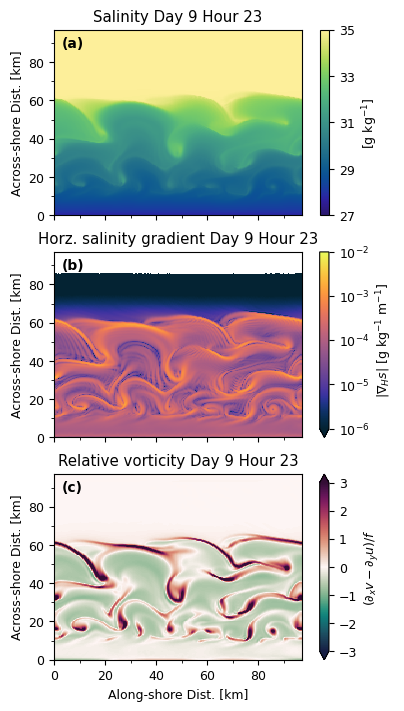

In [87]:
# plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(3,1, figsize = (7,7), constrained_layout = True)

#salt
tcount = -1
mappable = ax[0].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, salt1[tcount], cmap = cmo.haline, vmin = 27, vmax = 35)
cbar = fig.colorbar(mappable, ax = ax[0], label = '', pad = 0.03, ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'[g kg$^{-1}$]')

#Horizontal salinity gradient
mappable = ax[1].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, np.log10(sgrad1[tcount].where(sgrad1[tcount]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable, ax = ax[1], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'), pad = 0.03)
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

#Relative vertical vorticity 
mappable = ax[2].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, vort1[tcount], cmap = cmo.curl, vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable, ax = ax[2], label = '', extend = 'both', pad = 0.03)
cbar.ax.set_ylabel(r'$(\partial_x v - \partial_y u)/f$')

for i in range(3):
        ax[i].set(xlim=[0,97], ylim=[0,97], aspect = 0.75)
        ax[i].set_ylabel('Across-shore Dist. [km]')
        minor_locator = AutoMinorLocator(2)
        ax[i].xaxis.set_minor_locator(minor_locator)
        ax[i].yaxis.set_minor_locator(minor_locator)

ax[2].set_xlabel('Along-shore Dist. [km]')
for i in range(2):
        ax[i].set_xticklabels([])

ax[0].set_title('Salinity' + ' Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
ax[1].set_title('Horz. salinity gradient ' + 'Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
ax[2].set_title('Relative vorticity ' + 'Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
ax[0].annotate('(a)', xy = (3,88), color = 'k', fontsize = 10, fontweight='bold')
ax[1].annotate('(b)', xy = (3,88), color = 'k', fontsize = 10, fontweight='bold')
ax[2].annotate('(c)', xy = (3,88), color = 'k', fontsize = 10, fontweight='bold')


In [90]:
plt.rcParams.update({'font.size': 12})

for tcount in range(len(ds.ocean_time)):
    fig, ax = plt.subplots(3,1, figsize = (12,9), constrained_layout = True)

    #salt
    mappable = ax[0].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, salt1[tcount], cmap = cmo.haline, vmin = 27, vmax = 35)
    cbar = fig.colorbar(mappable, ax = ax[0], label = '', pad = 0.03, ticks = [27, 29, 31, 33, 35],)
    cbar.ax.set_ylabel(r'[g kg$^{-1}$]')

    #Horizontal salinity gradient
    mappable = ax[1].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, np.log10(sgrad1[tcount].where(sgrad1[tcount]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
    cbar = fig.colorbar(mappable, ax = ax[1], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'), pad = 0.03)
    cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

    #Relative vertical vorticity 
    mappable = ax[2].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, vort1[tcount], cmap = cmo.curl, vmin = -3, vmax = 3)
    cbar = fig.colorbar(mappable, ax = ax[2], label = '', extend = 'both', pad = 0.03)
    cbar.ax.set_ylabel(r'$(\partial_x v - \partial_y u)/f$')

    for i in range(3):
            ax[i].set(xlim=[0,97], ylim=[0,97], aspect = 0.75)
            ax[i].set_ylabel('Across-shelf dist. [km]')
            minor_locator = AutoMinorLocator(2)
            ax[i].xaxis.set_minor_locator(minor_locator)
            ax[i].yaxis.set_minor_locator(minor_locator)

    ax[2].set_xlabel('Along-shelf dist. [km]')
    for i in range(2):
            ax[i].set_xticklabels([])

    ax[0].set_title('Salinity: ' + 'Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
    ax[1].set_title('Horz. salinity gradient: ' + 'Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
    ax[2].set_title('Relative vorticity: ' + 'Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
    ax[0].annotate('(a)', xy = (3,88), color = 'k', fontsize = 10, fontweight='bold')
    ax[1].annotate('(b)', xy = (3,88), color = 'k', fontsize = 10, fontweight='bold')
    ax[2].annotate('(c)', xy = (3,88), color = 'k', fontsize = 10, fontweight='bold')


    path = '/d2/home/dylan/idealized_nummix/diurnal_wind/ani/shelf_dx_500_nowind_hour_'+ str(int(hours[tcount]))+'.jpg'
    # path = '/d2/home/dylan/idealized_nummix/diurnal_wind/ani/shelf_dx_500_diurnal_uwind_4_hour_'+ str(int(hours[tcount]))+'.jpg'
    # path = '/d2/home/dylan/idealized_nummix/diurnal_wind/ani/shelf_dx_500_semidiurnal_uwind_4_hour_'+ str(int(hours[tcount]))+'.jpg'
    plt.savefig(path, dpi = 300, bbox_inches='tight')
    plt.clf()

/tmp/ipykernel_5540/2843636674.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(3,1, figsize = (12,9), constrained_layout = True)

KeyboardInterrupt



<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

Error in callback <function flush_figures at 0x7f1bac402040> (for post_execute):



KeyboardInterrupt



# Old code below!

In [88]:
# plt.rcParams.update({'font.size': 13})

# for tcount in range(len(ds.ocean_time)):
#     fig, ax = plt.subplots(3,1, figsize = (12,9), constrained_layout = True)

#     #salt
#     mappable = ax[0].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, salt1[tcount], cmap = cmo.haline, vmin = 27, vmax = 35)
#     cbar = fig.colorbar(mappable, ax = ax[0], label = '', pad = 0.03, ticks = [27, 29, 31, 33, 35],)
#     cbar.ax.set_ylabel(r'[g kg$^{-1}$]')

#     #Horizontal salinity gradient
#     mappable = ax[1].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, np.log10(sgrad1[tcount].where(sgrad1[tcount]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
#     cbar = fig.colorbar(mappable, ax = ax[1], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'), pad = 0.03)
#     cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

#     #Relative vertical vorticity 
#     mappable = ax[2].pcolormesh(ds.x_rho[:]/1000, ds.y_rho[:]/1000, vort1[tcount], cmap = cmo.curl, vmin = -3, vmax = 3)
#     cbar = fig.colorbar(mappable, ax = ax[2], label = '', extend = 'both', pad = 0.03)
#     cbar.ax.set_ylabel(r'$(\partial_x v - \partial_y u)/f$')

#     for i in range(3):
#             ax[i].set(xlim=[0,97], ylim=[0,97], aspect = 0.75)
#             ax[i].set_ylabel('Across-shore Dist. [km]')
#             minor_locator = AutoMinorLocator(2)
#             ax[i].xaxis.set_minor_locator(minor_locator)
#             ax[i].yaxis.set_minor_locator(minor_locator)

#     ax[2].set_xlabel('Along-shore Dist. [km]')
#     for i in range(2):
#             ax[i].set_xticklabels([])

#     ax[0].set_title('Salinity' + ' Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
#     ax[1].set_title('Horz. salinity gradient ' + 'Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
#     ax[2].set_title('Relative vorticity ' + 'Day ' + str(int(timevec_days[tcount])) + ' Hour ' + str(hours_since0[tcount]))
#     ax[0].annotate('(a)', xy = (3,90), color = 'k', fontsize = 14, fontweight='bold')
#     ax[1].annotate('(b)', xy = (3,90), color = 'k', fontsize = 14, fontweight='bold')
#     ax[2].annotate('(c)', xy = (3,90), color = 'k', fontsize = 14, fontweight='bold')


#     # path = '/d2/home/dylan/idealized_nummix/diurnal_wind/ani/shelf_dx_500_nowind_hour_'+ str(int(hours[tcount]))+'.jpg'
#     # path = '/d2/home/dylan/idealized_nummix/diurnal_wind/ani/shelf_dx_500_diurnal_uwind_4_hour_'+ str(int(hours[tcount]))+'.jpg'
#     # path = '/d2/home/dylan/idealized_nummix/diurnal_wind/ani/shelf_dx_500_semidiurnal_uwind_4_hour_'+ str(int(hours[tcount]))+'.jpg'
#     plt.savefig(path, dpi = 300, bbox_inches='tight')
#     plt.clf()

# Plot the spatially-averaged wind forcing for the entire simulation

In [7]:
#diurnal wind
path = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/downwelling_5_diurnal/shelf_ho_5_dx_500_uwind_4_diurnal_avg.nc'
dsd = xroms.open_netcdf(path)
dsd, gridd = xroms.roms_dataset(dsd)

#Semidiurnal wind
path1 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/downwelling_5_semidiurnal/shelf_ho_5_dx_500_uwind_4_semidiurnal_avg.nc'
dssd = xroms.open_netcdf(path1)
dssd, gridd = xroms.roms_dataset(dssd)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

In [8]:
uwind_d = dsd.sustr.mean(['eta_rho', 'xi_u'])
uwind_sd = dssd.sustr.mean(['eta_rho', 'xi_u'])
timevec = np.arange(0,len(uwind_d))/24

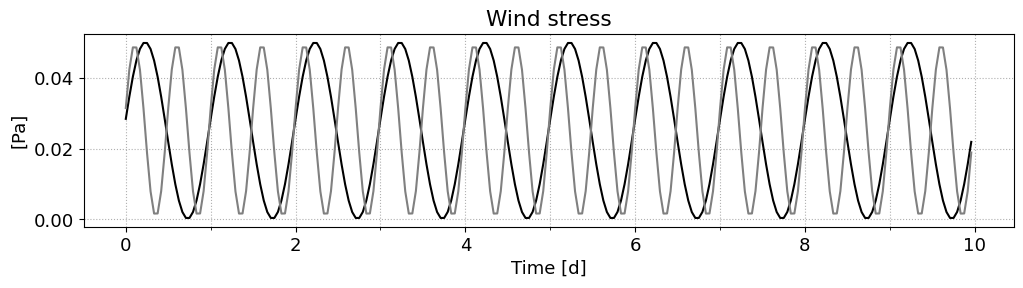

In [19]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax = plt.subplots(1, figsize = (12,2.5))

plt.plot(timevec, uwind_d, c = 'k')
plt.plot(timevec, uwind_sd, c = 'grey')
ax.grid(which = 'both',ls = ':')
plt.title('Wind stress')
plt.ylabel('[Pa]')
plt.xlabel('Time [d]')
ax.xaxis.set_minor_locator(MultipleLocator(1))

In [53]:
path = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/downwelling_5_semidiurnal/shelf_uwind_4_vwind_0_dx_500_sd_frc.nc'
frc = xr.open_dataset(path)
frc

<xarray.Dataset>
Dimensions:   (sms_time: 722)
Coordinates:
  * sms_time  (sms_time) timedelta64[ns] 00:00:00 ... 30 days 01:00:00.000028800
Data variables:
    sustr     (sms_time) float64 ...
    svstr     (sms_time) float64 ...
Attributes:
    Description:  Forcing for ideal shelf
    Author:       Dylan Schlichting
    Created:      2023-01-11T14:17:56.452580
    type:         ROMS FRC file

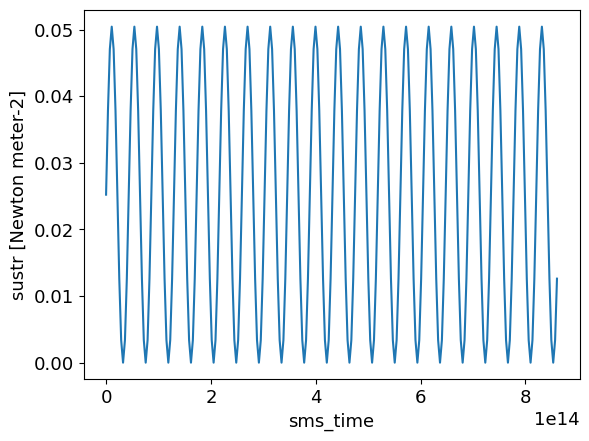

In [55]:
frc.sustr[:240].plot()

In [ ]:
# Look at numerical mixing 